# DL1 Assignment2 - Q1.1 draft code

This is a small help from us to save you some coding. This notebook is **not** graded, you are free to edit it.

Further advise:
1. Start with File/Save a copy in Drive
2. Set GPU usage under Runtime/Change runtime type/Hardware accelerator.

In [1]:
# !pip install timm

In [2]:
import torch
from torch import nn
import timm
from torchvision import models
from matplotlib import pyplot as plt
from typing import Callable

%matplotlib inline

In [3]:
def vit_s_8():
    """ViT-S/8 is not a default torchvision model, so we provide it by timm"""
    # Accuracy approximation comes from
    # https://openreview.net/pdf?id=LtKcMgGOeLt
    # and DINO
    # https://arxiv.org/abs/2104.14294
    return timm.create_model('vit_small_patch8_224')

# Model definitions
# Optional Q: These are uncalled functions. What do you think would happen
# if we called all of them once? Why didn't we do that?
model_defs = [
    vit_s_8,
    models.vit_b_32,
    models.vgg11,
    models.vgg11_bn,
    models.resnet18,
    models.densenet121,
    models.mobilenet_v3_small,
]

# Accuracies per model
model_accs = {
    'vit_s_8': 80., # Approximated
    'vit_b_32' : 75.912,
    'vgg11' : 69.02,
    'vgg11_bn' : 70.37,
    'resnet18' : 69.758,
    'densenet121' : 74.434,
    'mobilenet_v3_small' : 67.668,
}


def measure_runtime_per_forward(model:nn.Module, no_grad:bool, batch_size:int=8):
    """Measures the time for a single pass in milliseconds"""

    # Generate fake RGB input (224x224)
    #######################
    # PUT YOUR CODE HERE  #
    #######################
    mps_device = torch.device("mps")
    inp = torch.randn(batch_size, 3, 224, 224).to(mps_device)
    #######################
    # END OF YOUR CODE    #
    # #######################
    

    start = torch.mps.Event(enable_timing=True)
    end = torch.mps.Event(enable_timing=True)
    start.record()

    # Run the model
    #######################
    # PUT YOUR CODE HERE  #
    #######################
    model = model.to(mps_device)
    if no_grad:
        with torch.no_grad():
            model(inp)
    else:
        model(inp)
        
    #######################
    # END OF YOUR CODE    #
    #######################

    end.record()
    torch.mps.synchronize()
    return start.elapsed_time(end)


def evaluate_model(model_def:Callable, no_grad:bool, batch_size:int=8, passes:int=10):

    # Retreive initial memory allocation
    mps_device = torch.device("mps")

    # Define model
    model = model_def().to(mps_device).eval()
    # Access name as: model.__name__
    model.__name__ = model_def.__name__

    # Parameters that need to be filled
    n_params = None
    times, vrams = [], []
    mean_time = None
    mean_vram = None

    #######################
    # PUT YOUR CODE HERE  #
    #######################
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    #warmup for 3 passes
    for i in range(3):
        measure_runtime_per_forward(model, no_grad, batch_size)
    for i in range(passes):
        time = measure_runtime_per_forward(model, no_grad, batch_size)
        vram = torch.mps.current_allocated_memory()
        vram = vram/1024**2 #convert to MB
        n_params = trainable_params
        times.append(time)
        vrams.append(vram)
    mean_time = sum(times)/len(times)
    mean_vram = sum(vrams)/len(vrams)


    # Step 1: Calculate the number of **trainable** parameters
    # Step 2: Warm up with a few passes
    # Step 3: Run N forward passes and save the runtime +
    #         the vram allocated by the model
    # Step 4: Take the mean, preferably with dropping possible outliers

    #######################
    # END OF YOUR CODE    #
    #######################

    # Clean up space for the model
    del model
    torch.mps.empty_cache()

    return mean_time, mean_vram, n_params

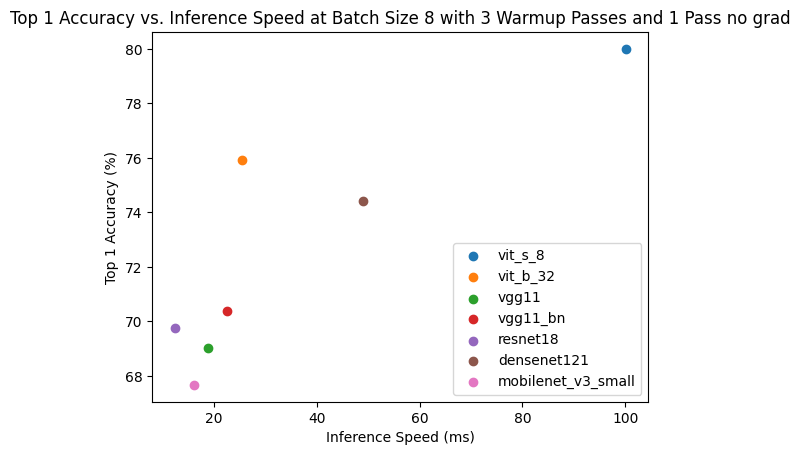

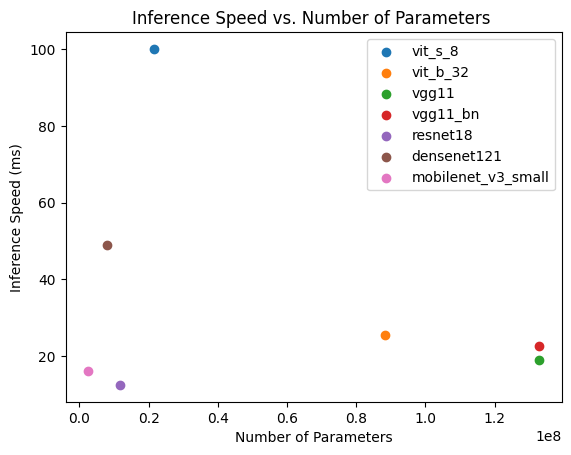

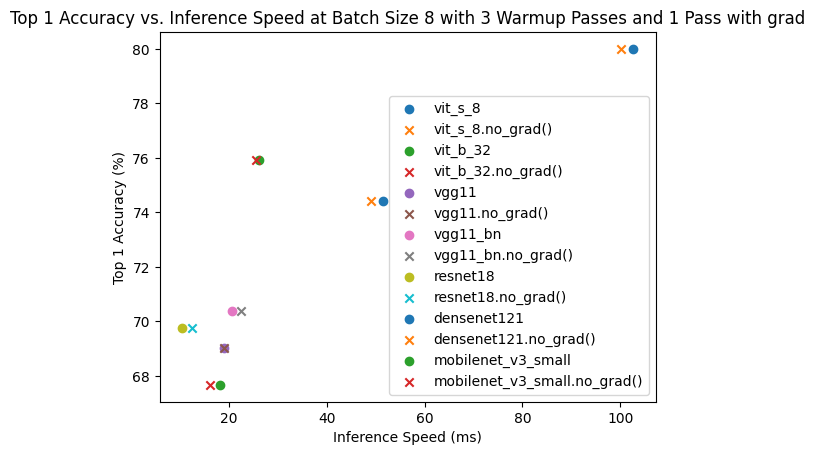

In [4]:
#######################
# PUT YOUR CODE HERE  #
#######################

import matplotlib.pyplot as plt

times, n_params, model_names, vrams = [], [], [], []
for model_def in model_defs:
    name = model_def.__name__
    time, vram, params = evaluate_model(model_def, no_grad=True, batch_size=8, passes=1)
    times.append(time)
    n_params.append(params)
    vrams.append(vram)
    model_names.append(name)




# Plot top 1 accuracy vs. inference speed at batch size 8
plt.figure()
for i in range(len(model_names)):
    plt.scatter(times[i], model_accs[model_names[i]], label=model_names[i])
plt.xlabel('Inference Speed (ms)')
plt.ylabel('Top 1 Accuracy (%)')
plt.title('Top 1 Accuracy vs. Inference Speed at Batch Size 8 with 3 Warmup Passes and 1 Pass no grad')
plt.legend()
plt.show()

# Plot inference speed vs. number of parameters
plt.figure()
for i in range(len(model_names)):
    plt.scatter(n_params[i], times[i], label=model_names[i])
plt.xlabel('Number of Parameters')
plt.ylabel('Inference Speed (ms)')
plt.title('Inference Speed vs. Number of Parameters ')
plt.legend()
plt.show()



times_with_grad, n_params_with_grad, model_names_with_grad, vram_with_grad = [], [], [], []
for model_def in model_defs:
    name = model_def.__name__
    time, _, params = evaluate_model(model_def, no_grad=False, batch_size=8, passes=1)
    times_with_grad.append(time)
    n_params_with_grad.append(params)
    model_names_with_grad.append(name)
    vram_with_grad.append(torch.mps.current_allocated_memory())


# Plot top 1 accuracy vs. inference speed at batch size 8 with grad
plt.figure()
for i in range(len(model_names_with_grad)):
    plt.scatter(times_with_grad[i], model_accs[model_names_with_grad[i]], label=model_names_with_grad[i]) # model_names_with_grad[i]
    plt.scatter(times[i], model_accs[model_names[i]], label=model_names[i] + ".no_grad()", marker='x')
plt.xlabel('Inference Speed (ms)')
plt.ylabel('Top 1 Accuracy (%)')
plt.legend()
plt.title('Top 1 Accuracy vs. Inference Speed at Batch Size 8 with 3 Warmup Passes and 1 Pass with grad')
plt.show()



times_with_grad_64, n_params_with_grad_64, model_names_with_grad_64, vram_with_grad_64 = [], [], [], []
for model_def in model_defs:
    name = model_def.__name__
    time, vram, params = evaluate_model(model_def, no_grad=False, batch_size=64, passes=10)
    times_with_grad_64.append(time)
    n_params_with_grad_64.append(params)
    model_names_with_grad_64.append(name)
    vram_with_grad_64.append(vram)

time_no_grad_64, n_params_no_grad_64, model_names_no_grad_64, vram_no_grad_64 = [], [], [], []
for model_def in model_defs:
    name = model_def.__name__
    time_, vram_grad, params_ = evaluate_model(model_def, no_grad=True, batch_size=64, passes=10)
    time_no_grad_64.append(time_)
    n_params_no_grad_64.append(params_)
    model_names_no_grad_64.append(name)
    vram_no_grad_64.append(vram_grad)

#plot vram per model with grad vs without grad
# plt.figure()
# for i in range(len(model_names_with_grad)):
#######################
# END OF YOUR CODE    #
#######################

[82.66552734375, 336.548828125, 506.83349609375, 506.87744140625, 44.633544921875, 30.7998046875, 9.77197265625]
[82.66552734375, 336.548828125, 506.83349609375, 506.87744140625, 44.633544921875, 30.7998046875, 9.77197265625]


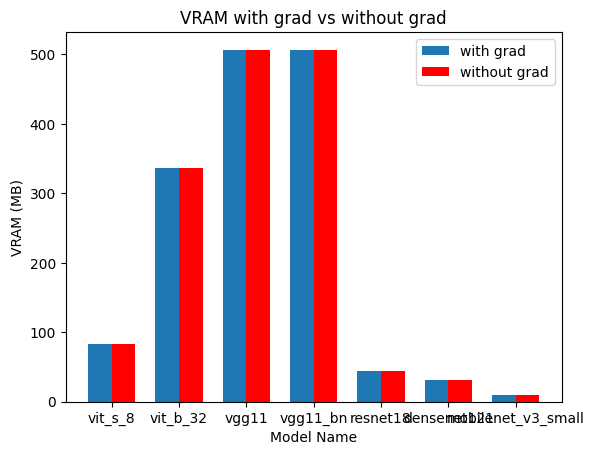

In [7]:

import numpy as np
# Bar plot of VRAM with grad vs without grad
bar_width = 0.35
index = np.arange(len(model_names_with_grad))

print(vram_with_grad_64), print(vram_no_grad_64)
plt.figure()
plt.bar(index, vram_with_grad_64, bar_width, label='with grad')
plt.bar(index + bar_width, vram_no_grad_64, bar_width, label='without grad', color='red')

plt.xlabel('Model Name')
plt.ylabel('VRAM (MB)')
plt.title('VRAM with grad vs without grad')
plt.xticks(index + bar_width / 2, model_names_with_grad)  # Position x-axis labels
plt.legend()
plt.show()

#

[82.66552734375, 336.548828125, 506.83349609375, 506.87744140625, 44.633544921875, 30.7998046875, 9.77197265625]
[82.66552734375, 336.548828125, 506.83349609375, 506.87744140625, 44.633544921875, 30.7998046875, 9.77197265625]


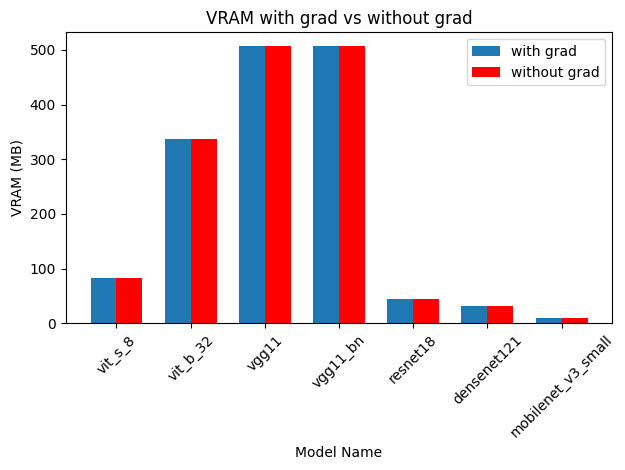

In [8]:
import numpy as np

# Bar plot of VRAM with grad vs without grad
bar_width = 0.35
index = np.arange(len(model_names_with_grad))

print(vram_with_grad_64), print(vram_no_grad_64)
plt.figure()
plt.bar(index, vram_with_grad_64, bar_width, label='with grad')
plt.bar(index + bar_width, vram_no_grad_64, bar_width, label='without grad', color='red')

plt.xlabel('Model Name')
plt.ylabel('VRAM (MB)')
plt.title('VRAM with grad vs without grad')
plt.xticks(index + bar_width / 2, model_names_with_grad, rotation=45)  # Rotate x-axis labels
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

**ANSWER** 1a) What we see in this case is that the models accuracy, and inference speed vs number of parameters. 

No it doens't scale proportionally, The trend that you see is that 